# COVID-19 in Australia

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#other-useful-information" data-toc-modified-id="other-useful-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>other useful information</a></span></li><li><span><a href="#functions" data-toc-modified-id="functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>functions</a></span></li></ul></li><li><span><a href="#Active-Cases" data-toc-modified-id="Active-Cases-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Active Cases</a></span></li><li><span><a href="#Source-of-infection" data-toc-modified-id="Source-of-infection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Source of infection</a></span></li><li><span><a href="#Hospitalised" data-toc-modified-id="Hospitalised-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hospitalised</a></span></li><li><span><a href="#Tests" data-toc-modified-id="Tests-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Tests</a></span></li><li><span><a href="#A-closer-look-at-Victoria" data-toc-modified-id="A-closer-look-at-Victoria-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>A closer look at Victoria</a></span></li><li><span><a href="#Local-cases---speculative" data-toc-modified-id="Local-cases---speculative-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Local cases - speculative</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python set-up

In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
import matplotlib.dates as mdates
import datetime

from pathlib import Path

from typing import Dict, List

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# scraping
from time import sleep
import requests
from bs4 import BeautifulSoup

# local imports
sys.path.append(r'../bin')
import plotstuff as ps

# plotting
plt.style.use('ggplot')
%matplotlib inline

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

### other useful information

In [2]:
# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS-'

source = 'Source: https://covidlive.com.au/'

DROP_TODAY = True

### functions

In [3]:
def get_dict_of_frames(url_stem: str, states: List[str])-> Dict[str, pd.DataFrame]:
    """Return a dictionary of scraped dataframes for each state"""
    
    rememberall = {}
    for state in states:
        url = url_stem + state
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'lxml')
        #print(soup.prettify())
        soup = soup.find('div', {'id': 'content'})
        tables = soup.findAll('table')
        for table in tables:
            if table.findParent("table") is None:
                df = pd.read_html(table.prettify(), header=0, index_col=0,
                                 na_values=['', '-'])[0]
                df = df.dropna(axis='columns', how='all')
                df = df.dropna(axis='rows', how='all')
                df.index = pd.DatetimeIndex(df.index + ' 2020')
                if DROP_TODAY:
                    df = df[df.index != 
                        pd.Timestamp(pd.Timestamp.today().date())]
                df = df.sort_index(ascending=True)
                rememberall[state.upper()] = df
            
        sleep(1) # let's be nice - not overload servers, etc.

    return rememberall

In [4]:
def get_most_recent(d: Dict[str, pd.DataFrame])-> Dict[str, pd.Series]:
    ret_val = {}
    for name in d:
        ret_val[name] = d[name].iloc[-1]
    return ret_val

In [5]:
def get_national_col(d: Dict[str, pd.DataFrame], col: str)-> pd.DataFrame:
    ret = {}
    for name in d:
        if col not in d[name].columns: 
            continue
        ret[name] = d[name][col]
    return pd.DataFrame(ret)

In [6]:
def plot_tidy_up(ax, title, space=True, rfooter=None):
    if space:
        xlim = ax.get_xlim()
        adj = (xlim[1] - xlim[0]) *0.01
        ax.set_xlim(xlim[0]-adj, xlim[1]+adj)

    fig = ax.figure
    fig.set_size_inches(8, 4)
    fig.text(0.99, 0.01, source,
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
            color='#999999')
    
    if rfooter is not None:
        fig.text(0.01, 0.01, rfooter,
            ha='left', va='bottom',
            fontsize=9, fontstyle='italic',
            color='#999999')
    
    fig.tight_layout(pad=1)
    
    title = title.replace('[:/]', '-')
    fig.savefig(f'{CHART_DIRECTORY}{title}.png', dpi=125)
    plt.show()
    plt.close


## Active Cases

In [7]:
colors = ['#ef4444', '#faa31b', '#eee000', '#82c341',
          '#009f75', 'dodgerblue', '#394ba0', '#d54799']   # '#88c6ed', 

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

In [8]:
states = ['nsw', 'vic', 'qld', 'wa', 'sa', 'tas', 'act', 'nt']
url_stem = 'https://covidlive.com.au/report/daily-active-cases/'
active_all = get_dict_of_frames(url_stem, states)
active_most_recent = get_most_recent(active_all)

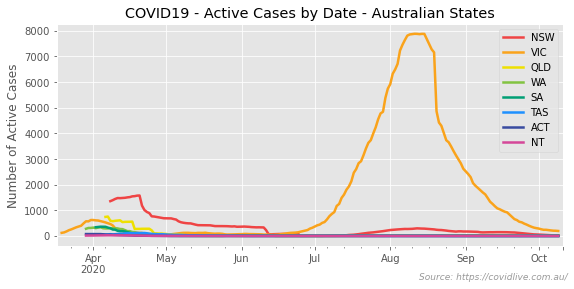

In [9]:
active = get_national_col(active_all, 'ACTIVE')
ax = active.plot.line(lw=2.5)
title = 'COVID19 - Active Cases by Date - Australian States'
ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel('Number of Active Cases')
plot_tidy_up(ax, title)

In [10]:
active = pd.DataFrame(active_most_recent).T
active = active.astype(float).astype(int) # makesure everything an integer
title = 'COVID19 - Active Cases - Australian States'
ps.plot_barh(active['ACTIVE'].sort_values(ascending=True), 
    title=title,
    xlabel='Currently active cases',
    savefig = f'{CHART_DIRECTORY}{title}.png',
    rfooter=source,
)

In [11]:
display(active)

,ACTIVE,NET
NSW,27,0
VIC,195,-8
QLD,4,0
WA,13,2
SA,3,0
TAS,0,0
ACT,0,0
NT,0,0


## Source of infection

In [12]:
states = ['nsw', 'vic', 'qld', 'wa', 'sa', 'tas', 'act', 'nt']
url_stem = 'https://covidlive.com.au/report/daily-source-of-infection/'
infection_all = get_dict_of_frames(url_stem, states)
infection_most_recent = get_most_recent(infection_all)

In [13]:
columns={
    'CONTACT': 'Contact',
    'I/STATE': 'Interstate',
    'INVES': 'Investigating',
    'O/SEAS': 'Overseas',
    'UNKNOWN': 'Unknown',
}

In [14]:
soi = pd.DataFrame(infection_most_recent).T
soi = soi.rename(columns = columns)
soi = soi[['Overseas', 'Interstate', 'Contact', 
           'Unknown', 'Investigating']]

,Overseas,Interstate,Contact,Unknown,Investigating
NSW,2369.0,91.0,1414.0,397.0,0.0
VIC,985.0,NaN,14978.0,4277.0,17.0
QLD,860.0,21.0,238.0,41.0,0.0
WA,599.0,6.0,72.0,15.0,0.0
SA,322.0,12.0,130.0,9.0,0.0
TAS,81.0,3.0,141.0,5.0,0.0
ACT,84.0,8.0,20.0,1.0,0.0
NT,27.0,4.0,2.0,0.0,0.0


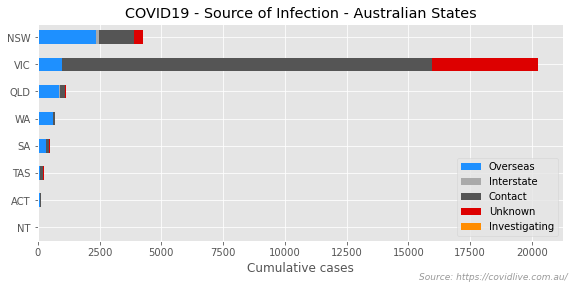

In [15]:
serious = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)
if soi.isna().any().any():
    print('Warning: there ara NaNs in the data, Vic does not report interstate')
    display(soi)        
    soi = soi.astype(float)
ax = soi[::-1].plot.barh(stacked=True)
title = 'COVID19 - Source of Infection - Australian States'

ax.set_title(title)
ax.set_xlabel('Cumulative cases')
ax.set_ylabel(None)

plot_tidy_up(ax, title, space=False)

In [16]:
imvestigate = get_national_col(infection_all, 'INVES')
imvestigate = imvestigate.astype(float)

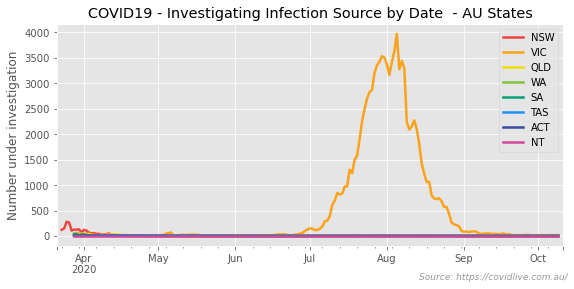

In [17]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
ax = imvestigate.plot.line(lw=2.5)
title = 'COVID19 - Investigating Infection Source by Date  - AU States'

ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel('Number under investigation')
plot_tidy_up(ax, title)

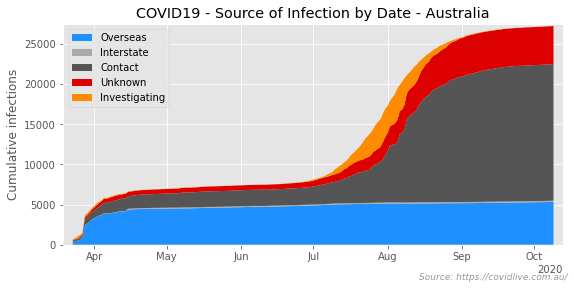

In [18]:
national_soi = pd.DataFrame()
for col in columns:
    national_soi[col] = get_national_col(infection_all, col).sum(axis=1)
national_soi = national_soi.rename(columns=columns)

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)

days = pd.to_datetime(national_soi.index)
fig, ax = plt.subplots()
ax.stackplot(days, national_soi['Overseas'], national_soi['Interstate'], national_soi['Contact'], 
               national_soi['Unknown'], national_soi['Investigating'], 
                labels = ['Overseas', 'Interstate', 'Contact', 'Unknown', 'Investigating'])
#ax = national_soi.plot(kind='bar', stacked=True)
title = 'COVID19 - Source of Infection by Date - Australia'

ax.set_title(title)
ax.set_xlabel(None)
ax.legend(loc='upper left')
ax.set_ylabel('Cumulative infections')
ax.margins(0.01)
plot_tidy_up(ax, title)

In [19]:
# compare the first and second Australia waves
point1 = pd.Timestamp('2020-05-31')
point2 = pd.Timestamp('2020-08-31')

total = national_soi.sum(axis=1)
w1 = pd.Series(dtype=float)
w2 = pd.Series(dtype=float)
for col in ['Overseas', 'Interstate', 'Contact', 'Unknown', 'Investigating']:
    at_point1 = national_soi[col].loc[point1], total.loc[point1] # tuple [column, total]
    at_point2 = national_soi[col].loc[point2], total.loc[point2] # tuple [column, total]
    w1[col] = at_point1[0] / at_point1[1] * 100
    w2[col] = (at_point2[0] - at_point1[0]) / (at_point2[1] - at_point1[1]) * 100
    print(f'First wave {col}%: {w1.iloc[-1]}')
    print(f'Second wave {col}%: {w2.iloc[-1]}')
    print('')
f'Check wave totals is 100% {w1.sum()}  {w2.sum()}'

First wave Overseas%: 63.13651137594799
Second wave Overseas%: 2.7447990414987475

First wave Interstate%: 1.5167930660888407
Second wave Interstate%: 0.17427295501579348

First wave Contact%: 26.909534127843987
Second wave Contact%: 73.78825835965581

First wave Unknown%: 8.193391115926326
Second wave Unknown%: 22.81886504738046

First wave Investigating%: 0.2437703141928494
Second wave Investigating%: 0.47380459644918854



'Check wave totals is 100% 99.99999999999999  100.0'

## Hospitalised

In [20]:
states = ['nsw', 'vic', 'qld', 'wa', 'sa', 'tas', 'act', 'nt']
url_stem = 'https://covidlive.com.au/report/daily-hospitalised/'
hospital_all = get_dict_of_frames(url_stem, states)
hospital_most_recent = get_most_recent(hospital_all)

In [21]:
hosp = pd.DataFrame(hospital_most_recent).T
hosp = hosp.astype(float)
display(hosp) # Vic often has missing ventilator data

,HOSP,ICU,VENT
NSW,7.0,2.0,0.0
VIC,17.0,1.0,0.0
QLD,4.0,1.0,0.0
WA,0.0,0.0,0.0
SA,0.0,0.0,0.0
TAS,0.0,0.0,0.0
ACT,0.0,0.0,0.0
NT,0.0,0.0,0.0


In [22]:
title = 'COVID19 - Hospitalised Cases - Australian States'
ps.plot_barh(hosp['HOSP'].astype(int).sort_values(ascending=True), 
    title=title,
    xlabel='Currently hospitalised cases',
    savefig = f'{CHART_DIRECTORY}{title}.png',
    rfooter=source,
)

In [23]:
title = 'COVID19 - ICU Cases - Australian States'
ps.plot_barh(hosp['ICU'].astype(int).sort_values(ascending=True), 
    title=title,
    xlabel='Current ICU cases',
    savefig = f'{CHART_DIRECTORY}{title}.png',
    rfooter=source,
)

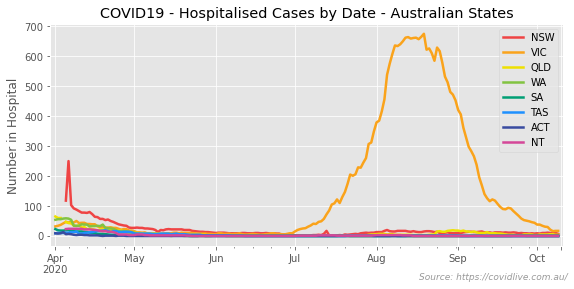

In [24]:
hosp = get_national_col(hospital_all, 'HOSP')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
ax = hosp.plot.line(lw=2.5)
title = 'COVID19 - Hospitalised Cases by Date - Australian States'

ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel('Number in Hospital')
plot_tidy_up(ax, title)

## Tests

In [25]:
states = ['nsw', 'vic', 'qld', 'wa', 'sa', 'tas', 'act', 'nt']
url_stem = 'https://covidlive.com.au/report/daily-tests/'
tests_all = get_dict_of_frames(url_stem, states)

In [26]:
state_pop = {
    # source: https://www.abs.gov.au/ausstats/abs@.nsf/Latestproducts/3101.0Main%20Features3Sep%202019?opendocument&tabname=Summary&prodno=3101.0&issue=Sep%202019&num=&view=
    'NSW': 8_118_000,
    'VIC': 6_629_900,
    'QLD': 5_115_500,
    'SA':  1_756_500,
    'WA':  2_630_600,
    'TAS':   535_500,
    'ACT':   428_100,
    'NT':    245_600,
}
power = 6
factor = 10 ** power
state_pop = pd.Series(state_pop) / factor

In [27]:
tests = get_national_col(tests_all, 'TESTS')
tests_daily_u, tests_daily_c, tests_c = ps.dataframe_correction(tests)

Negatives in VIC
DATE
2020-06-06   -12142.0
2020-08-08   -11984.0
Name: VIC, dtype: float64
Spikes in VIC
DATE     2020-09-03
spike  82309.000000
mean   16328.214286
zeros      0.000000
Spikes in QLD
DATE     2020-03-19  2020-06-22
spike  27064.000000     49207.0
mean     991.571429      4402.5
zeros      7.000000         0.0
Spikes in WA
DATE    2020-03-16
spike  5906.000000
mean    298.714286
zeros     7.000000
Negatives in TAS
DATE
2020-07-07   -707.0
Name: TAS, dtype: float64
Spikes in TAS
DATE    2020-03-29   2020-05-30
spike  1736.313243  3197.702098
mean     74.093097   609.527144
zeros     9.000000     0.000000
Spikes in ACT
DATE    2020-03-29
spike  4307.000000
mean     74.785714
zeros     7.000000
Negatives in NT
DATE
2020-07-15   -1022.0
Name: NT, dtype: float64
Spikes in NT
DATE    2020-07-14
spike  2439.429042
mean    303.768568
zeros     0.000000


In [28]:
ROLLING = 14
tests_daily_c = (tests_daily_c / state_pop).rolling(ROLLING).mean()
tests_daily_c = tests_daily_c[list(state_pop.keys())]

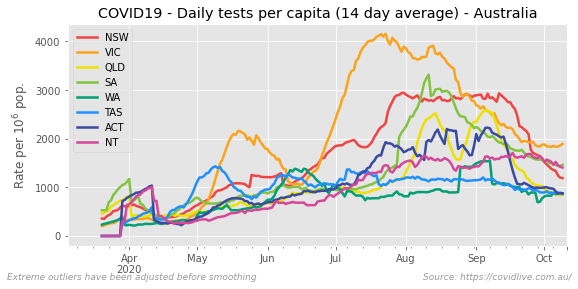

In [29]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
ax = tests_daily_c.plot.line(lw=2.5)
title = f'COVID19 - Daily tests per capita ({ROLLING} day average) - Australia'

ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel(f'Rate per $10^{power}$ pop.')
plot_tidy_up(ax, title, rfooter='Extreme outliers have been adjusted before smoothing')

## A closer look at Victoria

In [30]:
states = ['nsw', 'vic', 'qld', 'wa', 'sa', 'tas', 'act', 'nt']
url_stem = 'https://covidlive.com.au/report/daily-cases/'
cases_all = get_dict_of_frames(url_stem, states)

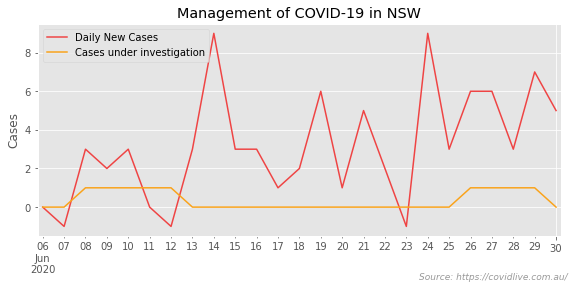

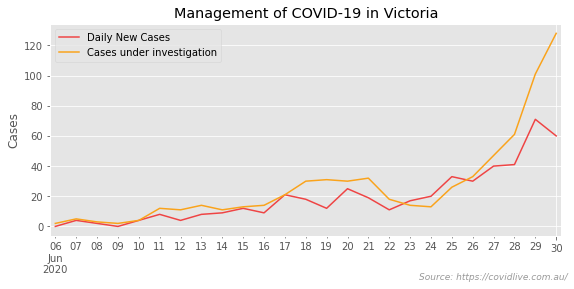

In [31]:
# critical start of the second wave
vic_new_cases = cases_all['VIC']['NET']
nsw_new_cases = cases_all['NSW']['NET']
vic_investigating = infection_all['VIC']['INVES']
nsw_investigating = infection_all['NSW']['INVES']
index = ['Daily New Cases', 'Cases under investigation']
nsw_sit = pd.DataFrame([nsw_new_cases, nsw_investigating], index=index).T
vic_sit = pd.DataFrame([vic_new_cases, vic_investigating], index=index).T
for data, state in zip([nsw_sit, vic_sit], ['NSW', 'Victoria']):
    data = data.loc[data.index >= pd.Timestamp('2020-06-06')]
    data = data.loc[data.index <= pd.Timestamp('2020-06-30')]
    ax = data.plot()
    title = f'Management of COVID-19 in {state}'
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel('Cases')
    plot_tidy_up(ax, title)
    

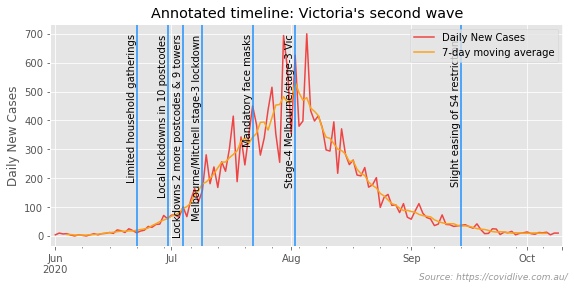

In [32]:
# Annotated Victorian timeline for its second wave 
data = (vic_sit.loc[vic_sit.index >= pd.Timestamp('2020-06-01')]).copy()
title = f"Annotated timeline: Victoria's second wave"
del data['Cases under investigation']
data['7-day moving average'] = data['Daily New Cases'].rolling(7, center=True).mean()

ax = data.plot()
ax.set_title(title)
ax.set_xlabel(None)
#ax.set_ylabel('Cases')
ax.set_ylabel('Daily New Cases')

def add_event(ax, y, text, date):
    args = {'rotation': 90, 'va': 'top', 'ha': 'right'}
    t = pd.Timestamp(date)
    ax.axvline(t, c='dodgerblue')
    ax.text(x=t, y=y, s=text, **args)

#y = data['Cases under investigation'].max()
y = data['Daily New Cases'].max()

# date of effect
# sourced from: https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Australia
add_event(ax, y, 'Limited household gatherings', '2020-06-22')
add_event(ax, y, 'Local lockdowns in 10 postcodes', '2020-06-30')
add_event(ax, y, 'Lockdowns 2 more postcodes & 9 towers', '2020-07-04')
add_event(ax, y, 'Melbourne/Mitchell stage-3 lockdown', '2020-07-09')
add_event(ax, y, 'Mandatory face masks', '2020-07-22')
add_event(ax, y, 'Stage-4 Melbourne/stage-3 Vic', '2020-08-02')
add_event(ax, y, 'Slight easing of S4 restrictions', '2020-09-14')

plot_tidy_up(ax, title)

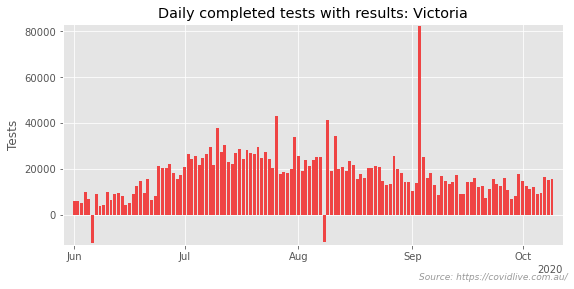

In [33]:
daily_tests_vic = tests_all['VIC']['NET']
daily_tests_vic = daily_tests_vic.iloc[daily_tests_vic.index >= pd.Timestamp('2020-06-01')]
title = f"Daily completed tests with results: Victoria"
fig, ax = plt.subplots()
ax.xaxis_date()
ax.margins(0.01)
ax.bar(daily_tests_vic.index, daily_tests_vic)

locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_title(title)
ax.set_xlabel(None)
ax.set_ylabel('Tests')
plot_tidy_up(ax, title)

## Local cases - speculative 

In [34]:
def recent(df, mode):
    RECENT = 28 # days
    MA1 = 7 # days
    MA2 = 14 # dats
    plt.style.use('ggplot')
    
    for col in df.columns:
        series = df[col]
        
        if series.iloc[-RECENT:].sum() <= 0: 
            continue
        ma1 = series.rolling(MA1).mean()
        ma2 = series.rolling(MA2).mean()
        
        MARGINS = 0.01
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        
        ax.bar(series.iloc[-RECENT:].index.values, series.iloc[-RECENT:], label=mode, color='#dd0000')
        ax.plot(ma1.iloc[-RECENT:].index.values, ma1.iloc[-RECENT:], label=f'{MA1} day ave.', color='darkorange')
        ax.plot(ma2.iloc[-RECENT:].index.values, ma2.iloc[-RECENT:], label=f'{MA2} day ave.', color='cornflowerblue')
        
        title = f'COVID19 Recent Locally Acquired {mode.title()} in {col} '
        ax.set_title(title)
        ax.set_ylabel(f'Daily New {mode.title()}')
        ax.legend(loc='best')

        fig = ax.figure
        fig.set_size_inches(8, 4)
        fig.text(0.99, 0.01, source,
            ha='right', va='bottom',
            fontsize=9, fontstyle='italic',
           color='#999999')
        fig.tight_layout(pad=1)

        fig.savefig(f'{CHART_DIRECTORY}{title}.png', dpi=125)
        plt.show()
        plt.close()

Negatives in NSW
DATE
2020-04-12   -3.0
2020-05-04   -2.0
2020-05-27   -3.0
2020-06-07   -1.0
2020-06-12   -1.0
2020-06-23   -1.0
Name: NSW, dtype: float64
Spikes in NSW
DATE   2020-04-15
spike  205.000000
mean    19.214286
zeros    1.000000
Negatives in QLD
DATE
2020-04-30   -1.0
2020-05-25   -5.0
2020-08-07   -1.0
2020-08-15   -1.0
2020-09-16   -1.0
Name: QLD, dtype: float64
Negatives in WA
DATE
2020-04-06   -148.0
2020-08-06    -28.0
Name: WA, dtype: float64
Spikes in WA
DATE   2020-04-05
spike  119.493424
mean    13.013258
zeros    0.000000
Spike not fixed for WA (1.337053006513591)
Negatives in SA
DATE
2020-08-05   -1.0
Name: SA, dtype: float64
Data too sparse in SA (max_consecutive=13)
Negatives in TAS
DATE
2020-04-20   -2.0
Name: TAS, dtype: float64
Negatives in ACT
DATE
2020-04-12   -1.0
Name: ACT, dtype: float64
Data too sparse in ACT (max_consecutive=7)
Data too sparse in NT (max_consecutive=2)
Negatives in NSW
DATE
2020-05-05    -1.0
2020-06-08   -11.0
Name: NSW, dtype: floa

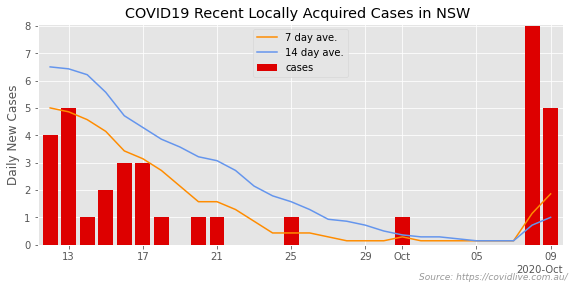

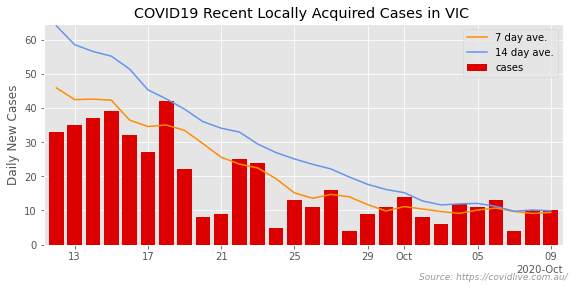

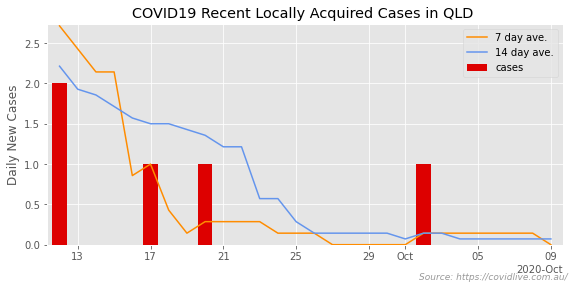

quick and dirty - overseas acquired


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
DATE,,,,,,,,
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-27,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0
2020-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-29,2.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2020-09-30,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-01,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-10-02,4.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
2020-10-03,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-10-04,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


quick and dirty - locally acquired


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
DATE,,,,,,,,
2020-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-27,0.0,16.0,0.0,-1.0,0.0,0.0,0.0,0.0
2020-09-28,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-29,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-09-30,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-01,1.0,14.0,0.0,-1.0,0.0,0.0,0.0,0.0
2020-10-02,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-10-03,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-04,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
all_cum = pd.DataFrame()
overseas_cum = pd.DataFrame()
for state, frame in infection_all.items():
    frame = frame.ffill()
    frame = frame.fillna(0)
    all_cum[state] = frame.sum(axis=1)
    overseas_cum[state] = frame['O/SEAS']
    if 'I/STATE' in frame.columns:
        overseas_cum[state] += frame['I/STATE']

(all_uc_daily_new, all_c_daily_new, 
    all_c_cumulative) = ps.dataframe_correction(all_cum)
(os_uc_daily_new,  os_c_daily_new, 
    os_c_cumulative) =  ps.dataframe_correction(overseas_cum)
local_cum = all_c_cumulative - os_c_cumulative
local_daily = local_cum.diff()

recent(local_daily, "cases")

print('quick and dirty - overseas acquired')
display(overseas_cum.iloc[-14:].diff())

print('quick and dirty - locally acquired')
display((all_cum - overseas_cum).iloc[-14:].diff())

## The End

In [36]:
print('Finished')

Finished
